# Apply a trained SRFlow model

## Reproduce using our Setup

- Use the ./setup.sh
- It install the all packages from the requirements.txt
- If this notebook does not work, copy the code to start it from setup.py
- The python interpreter should be '../myenv/bin/python3'

In [1]:
import sys, os
import random
from tqdm import tqdm
from models.modules.flow import GaussianDiag
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
sys.path.insert(0,'/workspace/CTFlow/code')

In [4]:
print(sys.path)

['/workspace/CTFlow/code', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython']


# Initialize

In [5]:
import natsort, glob, pickle, torch, imageio
from collections import OrderedDict
import numpy as np
import os

import options.options as option
from models import create_model
from imresize import imresize

import Measure

def find_files(wildcard): return natsort.natsorted(glob.glob(wildcard, recursive=True))

from PIL import Image
def imshow(array, max_val=1176):
    array = np.clip(array, 0, max_val) / max_val
    array = np.round( array * 255).astype('uint8')    
    array = np.repeat(array, 3, axis=2)        
    display(Image.fromarray(array))

from test import load_model, fiFindByWildcard, imread

def pickleRead(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [6]:
# Convert to tensor
def t(array): 
    array = np.expand_dims(array.transpose([2, 0, 1]), axis=0).astype(np.float32)
    array = np.clip(array, 0, 1500)
    return torch.Tensor(array) / 1500.

# convert to image
def rgb(t, dtype='uint8'): 
    out = (t[0] if len(t.shape) == 4 else t).detach().cpu().numpy()
    out = out.transpose([1, 2, 0])
    if dtype == 'uint8':
        out = (np.clip(out, 0, 1) * 255).astype(np.uint8)
    if dtype == 'uint16':
        out = (np.clip(out, 0, 1) * 1500).astype(np.uint16)
    return out

# List model files

If you do not see models here, download them as in `setup.sh`.

In [7]:
# find_files("../experiments/train_SRFlow_UCLA_k1_to_k3/models/*.pth")

# Configuration files


In [8]:
find_files("confs/*.yml")

['confs/RRDB_CelebA_8X.yml',
 'confs/RRDB_DF2K_4X.yml',
 'confs/RRDB_DF2K_8X.yml',
 'confs/RRDB_UCLA_4X.yml',
 'confs/RRDB_UCLA_k1_to_k2.yml',
 'confs/RRDB_UCLA_k2_to_k1.yml',
 'confs/RRDB_UCLA_k2_to_k2.yml',
 'confs/RRDB_UCLA_k3_to_k2.yml',
 'confs/RRDB_UCLA_k3_to_k3.yml',
 'confs/SRFlow_CelebA_8X.yml',
 'confs/SRFlow_DF2K_4X.yml',
 'confs/SRFlow_DF2K_8X.yml',
 'confs/SRFlow_UCLA_4X.yml',
 'confs/SRFlow_UCLA_k1_to_k2.yml',
 'confs/SRFlow_UCLA_k2_to_k1.yml',
 'confs/SRFlow_UCLA_k2_to_k2.yml',
 'confs/SRFlow_UCLA_k3_to_k2.yml',
 'confs/SRFlow_UCLA_k3_to_k3.yml']

# List dataset directories


In [9]:
find_files("../datasets/**/")

[]

In [715]:
conf_path = './confs/SRFlow_UCLA_k2_to_k1.yml'
# conf_path = './confs/SRFlow_UCLA_k2_to_k2.yml'
# conf_path = './confs/RRDB_UCLA_k3_to_k2.yml'
# conf_path = './confs/RRDB_UCLA_k1_to_k2.yml'

### Instancieate the Model

In [716]:
model, opt = load_model(conf_path)

export CUDA_VISIBLE_DEVICES=1
OrderedDict([('manual_seed', 10), ('lr_G', 0.0001), ('weight_decay_G', 0), ('beta1', 0.9), ('beta2', 0.99), ('lr_scheme', 'MultiStepLR'), ('warmup_iter', -1), ('lr_steps_rel', [0.5, 0.75, 0.9, 0.95]), ('lr_gamma', 0.5), ('niter', 100000), ('val_freq', 10000), ('lr_steps', [50000, 75000, 90000, 95000])])


In [717]:
# opt['dataroot_LR'] = '/dingo/data/leihaowei/nastaran_test_h5_png/k3_d10_st1.0'
# opt['dataroot_GT'] = '/dingo/data/leihaowei/nastaran_test_h5_png/k1_d100_st1.0'
print(opt['path']['pretrain_model_G'])
print(opt['model_path'])

../experiments/train_RRDB_UCLA_k2_d10_to_k1_nb14/models/300000_G.pth
../experiments/train_SRFlow_UCLA_k2_d10_to_k1/models/100000_G.pth


### Find the png paths

In [718]:
lq_paths = fiFindByWildcard(os.path.join(opt['dataroot_LR'], '*.png'))
gt_paths = fiFindByWildcard(os.path.join(opt['dataroot_GT'], '*.png'))
# print(lq_paths, gt_paths) # For CelebA we have just 1

In [719]:
print(lq_paths[0], gt_paths[0]) 

/dingo/data/leihaowei/nastaran_test_h5_png/k2_d10_st1.0/0b8d8007e644433276d957fc2859b620_0.png /dingo/data/leihaowei/nastaran_test_h5_png/k1_d100_st1.0/0b8d8007e644433276d957fc2859b620_0.png


In [720]:
random.seed(42)
lq_path_sub = random.sample(lq_paths, 1000)
random.seed(42)
gt_path_sub = random.sample(gt_paths, 1000)

lqs = [imread(p) for p in lq_path_sub]
gts = [imread(p) for p in gt_path_sub]

An LR image


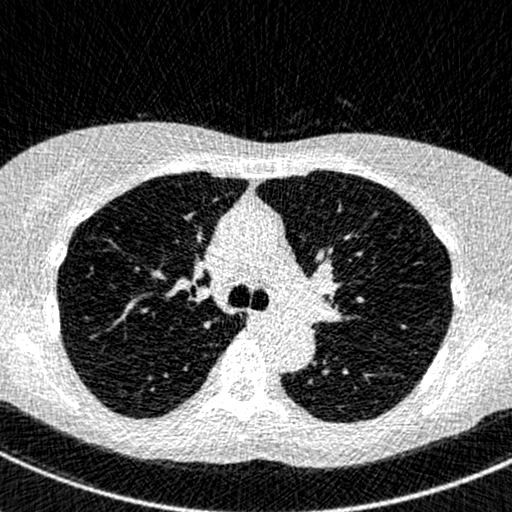

An HR image


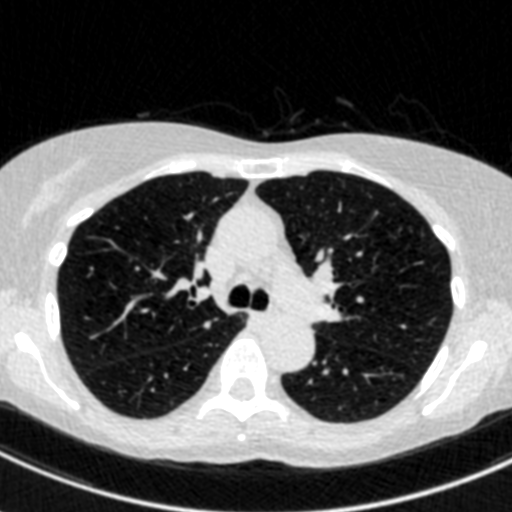

In [721]:
print("An LR image")
imshow(lqs[30], max_val=1176)

print("An HR image")
imshow(gts[30], max_val=1176)

# Super-Resolve using SRFlow for multiple temperatures

In [722]:
measure = Measure.Measure()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.6/dist-packages/lpips/weights/v0.1/alex.pth


In [742]:
epses_w = model.get_encode_z(lq=t(lqs[2]), gt=t(gts[2]), epses=[])
epses_w_copy = epses_w.copy()
for lq, gt in tqdm(zip(lqs[3:500], gts[3:500])):
    epses_w = model.get_encode_z(lq=t(lq), gt=t(gt), epses=[])
    mean_z1 = epses_w[0].mean(axis=(1,2,3))
    var_z1 = epses_w[0].var(axis=(1,2,3))
    if abs(mean_z1) < 1 and var_z1 < 10 :
        for i, z_w in enumerate(epses_w):
            epses_w_copy[i] = torch.cat((epses_w_copy[i], z_w), 0)               

0it [00:00, ?it/s]


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [724]:
epses_w_copy[0].shape

torch.Size([447, 2, 256, 256])

In [725]:
epses_w_learned = epses_w_copy

Atlas image


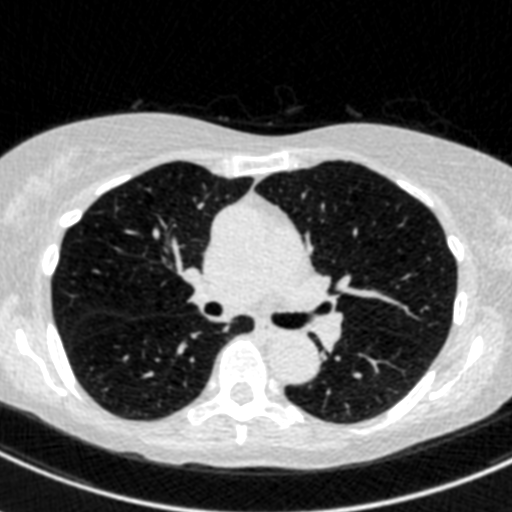

In [744]:
lq = lqs[30]
gt = gts[30]
tau = 0.8
template_id=559
print("Atlas image")
imshow(gts[template_id])

## Sample a z vector (last level)

In [727]:
z = model.get_z(tau, batch_size=1, lr_shape=t(lq).shape).to('cuda:0')

## get encoded z vector given LR/atlas pair

In [728]:
epses = model.get_encode_z(lq=t(lqs[template_id]), gt=t(gts[template_id]), epses=[])
# epses = model.get_encode_z(lq=t(lq), gt=t(gts[template_id]), epses=[])

In [729]:
def get_z_hat(heat, zw, z):
    n = zw.shape[0]
    mean = torch.tensor(np.random.normal(0, heat/n))
    var = torch.tensor(np.random.gamma((n-1)/2, 2*heat/(n-1)))
    # spatial normalization for channels
    mean_zw = torch.mean(zw, dim=(0,2,3), keepdim=True)
    var_zw = torch.var(zw, dim=(0,2,3), keepdim=True)
    return torch.sqrt(var/var_zw) * (z - mean_zw) + mean, mean, var

# def get_z_hat(zw, z, mean=0., var = 0.):
#     _, C, H, W = zw.shape
#     # spatial normalization for channels
#     mean_zw = torch.mean(zw, dim=(0,2,3), keepdim=True)
#     var_zw = torch.var(zw, dim=(0,2,3), keepdim=True)
    
#     z = torch.normal(mean=torch.ones(1, C, H, W).to(zw.device) * mean_zw, 
#                         std=torch.ones(1, C, H, W).to(zw.device) * torch.sqrt(var_zw))
    
#     return torch.sqrt(var/var_zw) * (z - mean_zw) + mean, mean, var

## re-normalized z vector given previously learned z = f(LR, atlas)

In [730]:
epses_hat = []
for zw, z in zip(epses_w_learned, epses):
    z_hat, mean, var = get_z_hat(tau, zw, z)
#     z_hat, mean, var = get_z_hat(zw, z, mean = 0, var=tau**2)
    epses_hat.append(z_hat)
    print(mean, var, z_hat.mean(), z_hat.var())

tensor(-0.0018) tensor(0.7636) tensor(-0.0015, device='cuda:0') tensor(0.6338, device='cuda:0')
tensor(0.0003) tensor(0.8500) tensor(0.0028, device='cuda:0') tensor(0.8992, device='cuda:0')
tensor(-0.0010) tensor(0.7090) tensor(-0.0011, device='cuda:0') tensor(0.7156, device='cuda:0')


## with latent vector normalization

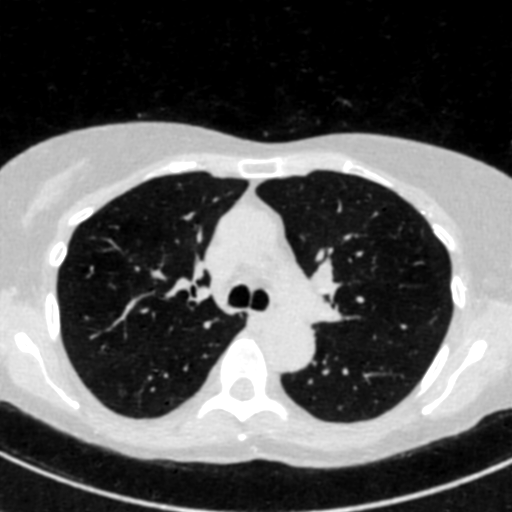

Temperature: 0.80 - PSNR: 24.13, SSIM: 0.8470, LPIPS: 0.1348


In [731]:
sr = rgb(model.get_sr_with_z(lq=t(lq), heat=tau, z=None, epses=epses_hat)[0], dtype='uint8')
# sr = rgb(model.get_sr(lq=t(lq))[0], dtype='uint8')
gt_uint8 = (gt/1500*255).astype(np.uint8)
imshow(sr, max_val=200)
psnr, ssim, lpips = measure.measure(sr, gt_uint8)
print('Temperature: {:0.2f} - PSNR: {:0.2f}, SSIM: {:0.4f}, LPIPS: {:0.4f}'.format(tau, psnr, ssim, lpips))

## without 

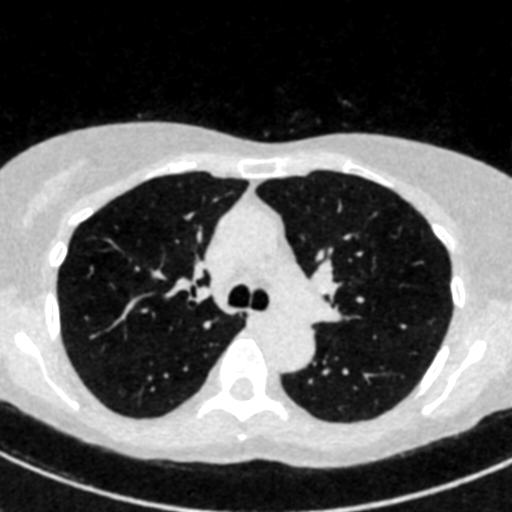

Temperature: 0.80 - PSNR: 24.08, SSIM: 0.8326, LPIPS: 0.1206


In [759]:
# sr = rgb(model.get_sr_with_z(lq=t(lq), heat=tau, z=z)[0], dtype='uint8')
sr = rgb(model.get_sr(lq=t(lq), heat=0.8)[0], dtype='uint8')
gt_uint8 = (gt/1500*255).astype(np.uint8)
imshow(sr, max_val=200)
psnr, ssim, lpips = measure.measure(sr, gt_uint8)
print('Temperature: {:0.2f} - PSNR: {:0.2f}, SSIM: {:0.4f}, LPIPS: {:0.4f}'.format(tau, psnr, ssim, lpips))

## GT

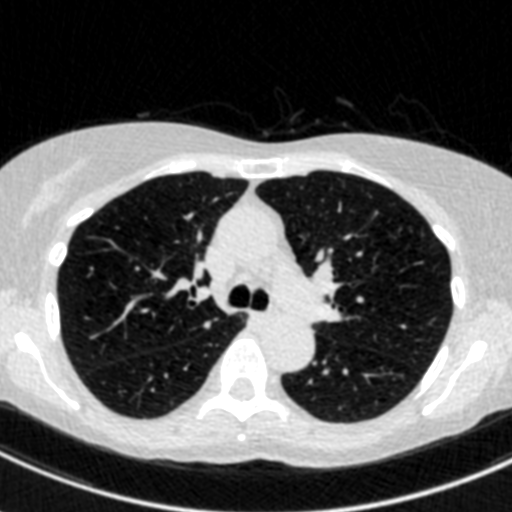

In [733]:
imshow(gt)

In [205]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [206]:
# old_epses = epses[1] # k3 to k2
new_epses = epses[1] # k2 to k2

In [207]:
plt.imshow( gram_matrix(old_epses).cpu().numpy(),vmin=-0.03, vmax=0.06)
plt.colorbar()
plt.show()

NameError: name 'old_epses' is not defined

In [ ]:
plt.imshow( gram_matrix(new_epses).cpu().numpy(),vmin=-0.03, vmax=0.06)
plt.colorbar()
plt.show()

In [ ]:
plt.imshow( gram_matrix(epses_hat[1]).cpu().numpy(),vmin=-0.03, vmax=0.06)
plt.colorbar()
plt.show()

In [ ]:
new_epses[0].mean(), new_epses[0].var()

In [ ]:
epses_hat[0].mean(), epses_hat[0].var()

In [ ]:
gram_matrix(old_epses[0]).cpu().numpy() - gram_matrix(new_epses[0]).cpu().numpy()

In [ ]:
new_epses = epses

In [ ]:
gram_matrix(old_epses[0]).cpu().numpy(), gram_matrix(new_epses[0]).cpu().numpy()

In [ ]:
gram_matrix(old_epses[1]).cpu().numpy(), gram_matrix(new_epses[1]).cpu().numpy()

In [ ]:
old_epses[0] - new_epses[0]

In [ ]:
lq = lqs[500]
gt = gts[500]
images=[]
for temperature in np.linspace(0, 0.95, num=10):
    # Sample a super-resolution for a low-resolution image
    sr = rgb(model.get_sr(lq=t(lq), heat=temperature), dtype='uint8')
    z_w = model.get_encode_z(lq=t(lq), gt=t(gt))
    gt_uint8 = (gt/1500*255).astype(np.uint8)
    images.append(Image.fromarray(np.repeat(sr,3, axis=2)))

    imshow(sr, max_val=255)
    psnr, ssim, lpips = measure.measure(sr, gt_uint8)
    print('Temperature: {:0.2f} - PSNR: {:0.2f}, SSIM: {:0.4f}, LPIPS: {:0.4f}'.format(temperature, psnr, ssim, lpips))

# Create animation from multiple samples using SRFlow 

In [ ]:
lq = lqs[99]
gt = gts[99]
images=[]
psnrs = []
ssims = [] 
lpipss = []
temperature=0.75
for _ in range(60):
    # Sample a super-resolution for a low-resolution image
    sr = rgb(model.get_sr(lq=t(lq), heat=temperature), dtype='uint8')
    images.append(Image.fromarray(np.repeat(sr,3, axis=2)))
    psnr, ssim, lpips = measure.measure(sr, gt_uint8)
    psnrs.append(psnr)
    ssims.append(ssim)
    lpipss.append(lpips) 
    print('Temperature: {:0.2f} - PSNR: {:0.2f}, SSIM: {:0.4f}, LPIPS: {:0.4f}'.format(temperature, psnr, ssim, lpips))
imageio.mimsave('out.gif', images, fps=10) 

In [ ]:
np.std(psnrs), np.std(ssims), np.std(lpipss)

# LR Consistency

In [ ]:
lq = lqs[0]
gt = gts[0]

temperature = 

downsampled = lq
for idx in range(5):
    sr = rgb(model.get_sr(lq=t(downsampled), heat=temperature))
    downsampled = imresize(sr, 1/8)
    
    imshow(abs(downsampled-lq))


In [ ]:
sr0 = rgb(model.get_sr(lq=t(downsampled), heat=temperature))
sr1 = rgb(model.get_sr(lq=t(downsampled), heat=temperature))
imshow(abs(sr0-sr1))

In [ ]:
stack=[]
for _ in range(100):
    stack.append( rgb(model.get_sr(lq=t(downsampled), heat=temperature)))

In [ ]:
images=[Image.fromarray(im) for im in stack]

In [ ]:
im = Image.new(mode='RGB',size=(160,160))
im.save('out.gif',save_all=True, append_images=images)